Data Structure:
  **Rows:**  
  - 0: Column Headers
  - 1 - 531 : Patient ID Number *(int)*

  **Columns:**
  - 0: DID *(int):* Patient ID
  - 1: Mutation *(string)*: CTL (Control), MAPT, C9orf72, GRN
  - 2: AGE_AT_VISIT *(int)*
  - 3: SEX_AT_BIRTH *(string)*: M, F
  - 4: Carrier.Status *(string)*: Carrier, CTL
  - 5: Gene.Dx *(string)*:  mutation status + clinical status
  (“PreSx” suffix = presymptomatic and “Sx” suffix = symptomatic)
  - 6: GLOBALCOG.ZCORE *(float)*: global cognition composite score
  - 7: FTLDCDR_SBL *(int)*: CDR sum of boxes - Clinical Dementia Rating Scale (CDR)
  is a global assessment instrument that yields global and Sum of Boxes (SOB) scores,
  with the global score regularly used in clinical and research settings
  to stage dementia severity. Higher is worse.
  - 8: NFL3_MEAN *(float):* plasma NfL concentrations
  - 9: HasPlasma? *(int)*: 1, 0 (519 Yes)
  - 10 - 7298: Proteins *(float)*:
    Protein variables are annotated as
    Protein Symbol | UniProt ID^Sequence ID| Matrix (CSF or PLASMA).
    The sequence ID is present only if there is more than one target
    for a given protein: e.g.,
    ABL2|P42684^SL010488@seq.3342.76|PLASMA ,
    ABL2|P42684^SL010488@seq.5261.13|PLASMA
  - 7299: HasCSF? *(int)*: 1, 0 (254 Yes)
  - 7300 - 14588: Proteins *(float)*:
  - 14589 - 15212: Clinical Data - maybe not necessary for right now.


/tmp/ipykernel_57052/3705087891.py:6: DtypeWarning: Columns (14923,14929,14930,15002,15004,15005,15006,15007) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/raw/ALLFTD_dataset_for_nina_louisa.csv')


The number of 'CTL' in the 'Carrier.Status' column is: 192
The number of 'Carrier' in the 'Carrier.Status' column is: 338


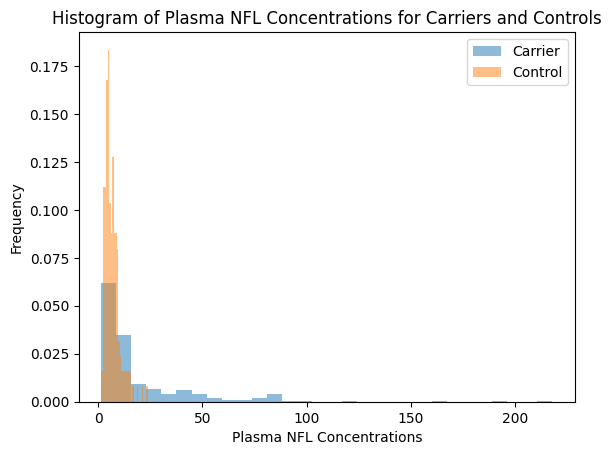

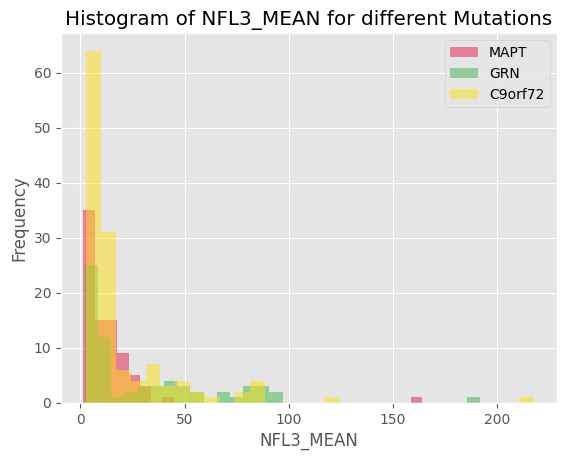

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Load the data
data = pd.read_csv('../data/raw/ALLFTD_dataset_for_nina_louisa.csv')

# Display the first few rows of the data
data.head()

ctl_count = data['Carrier.Status'].value_counts()['CTL']
print(f"The number of 'CTL' in the 'Carrier.Status' column is: {ctl_count}")

carrier_count = data['Carrier.Status'].value_counts()['Carrier']
print(f"The number of 'Carrier' in the 'Carrier.Status' column is: {carrier_count}")


controls = data[data['Carrier.Status'].str.contains('CTL')]
# Plot a histogram of the 'NFL3_MEAN' column

carriers = data[data['Carrier.Status'].str.contains('Carrier')]

plt.hist(carriers['NFL3_MEAN'], bins=30, alpha=0.5, label='Carrier', density=True)
plt.hist(controls['NFL3_MEAN'], bins=30, alpha=0.5, label='Control', density=True)

# Add title and labels
plt.title('Histogram of Plasma NFL Concentrations for Carriers and Controls')
plt.xlabel('Plasma NFL Concentrations')
plt.ylabel('Frequency')
# Add legend
plt.legend()

plt.figure()
plt.style.use('ggplot') 
my_palette = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4']
sns.set_palette(my_palette)

# Filter data based on Mutation
mapt_data = data[data['Mutation'] == 'MAPT']['NFL3_MEAN']
grn_data = data[data['Mutation'] == 'GRN']['NFL3_MEAN']
c903_data = data[data['Mutation'] == 'C9orf72']['NFL3_MEAN']

# Plot histograms
plt.hist(mapt_data, bins=30, alpha=0.5, label='MAPT')
plt.hist(grn_data, bins=30, alpha=0.5, label='GRN')
plt.hist(c903_data, bins=30, alpha=0.5, label='C9orf72')

plt.xlabel('NFL3_MEAN')
plt.ylabel('Frequency')
plt.title('Histogram of NFL3_MEAN for different Mutations')
plt.legend(loc='upper right')

plt.show()





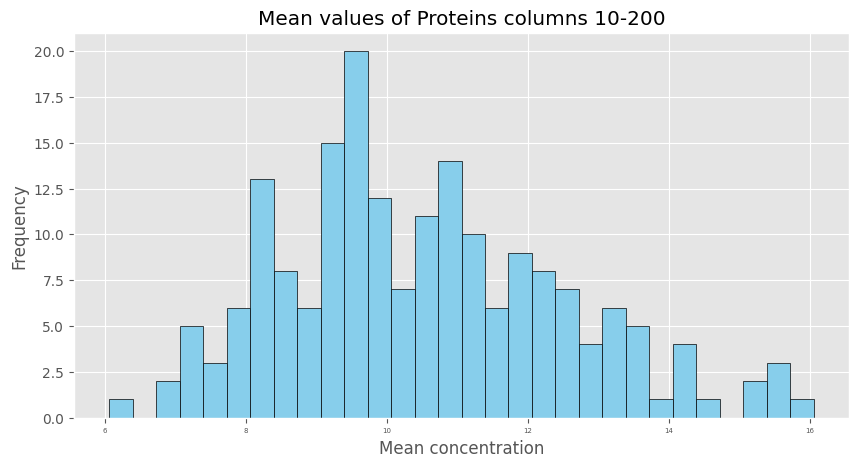

In [4]:
mean_values = data.iloc[:, 10:200].mean()

plt.figure(figsize=(10,5))
mean_values.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Mean values of Proteins columns 10-200')
plt.ylabel('Frequency')
plt.xlabel('Mean concentration')
plt.tick_params(axis='x', labelsize=5)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


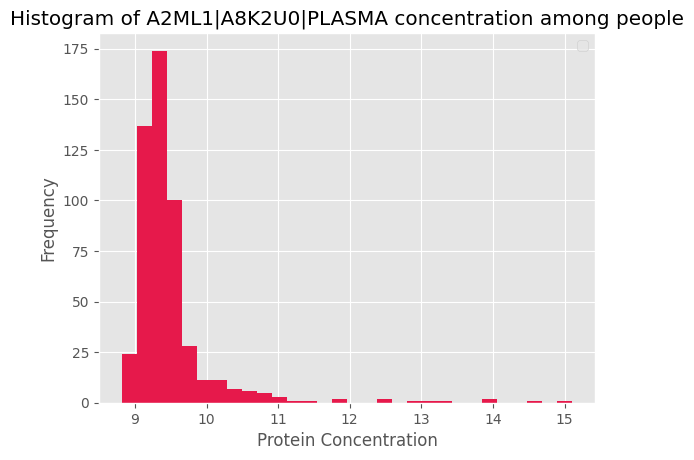

In [5]:
# Plot a histogram of column 30 protein concentration
data['A2ML1|A8K2U0|PLASMA'].hist(bins=30)
plt.xlabel('Protein Concentration')
plt.ylabel('Frequency')
plt.title('Histogram of A2ML1|A8K2U0|PLASMA concentration among people')
plt.legend(loc='upper right')

In [3]:
# Finding 30 most different
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency, ttest_ind
ks_stats = []

mutation_map = {
    "GRN": ["GRN.PreSx", "GRN.Sx"],
    "MAPT": ["MAPT.PreSx", "MAPT.Sx"],
    "C9": ["C9.PreSx", "C9.Sx"],
    "CTL": ["CTL"]
}

if "CTL" in mutation_map:
    mutation_values = mutation_map["CTL"]
    condition1 = data['Gene.Dx'].isin(mutation_values)
    condition2 = ~data['Gene.Dx'].isin(mutation_values)
else:
    raise ValueError("Invalid mutation status specified.")

for i in range(10, 7299):
    protein_column = data.columns[i]

    mutation_data = data[condition1][protein_column]
    other_data = data[condition2][protein_column]

    mutation_data = mutation_data.dropna()
    other_data = other_data.dropna()
    mutation_data = mutation_data[np.isfinite(mutation_data)]
    other_data = other_data[np.isfinite(other_data)]

    ks_statistic, ks_p_value = ks_2samp(mutation_data, other_data)
    ks_stats.append((protein_column, i, ks_statistic, ks_p_value))

ks_stats_df = pd.DataFrame(ks_stats, columns=['Protein', 'Column', 'KS_Statistic', 'P Value'])
top_columns = ks_stats_df.sort_values(by='P Value', ascending=True).head(30)


# Display the top 30 columns with highest KS statistic values
#print(top_columns)
print(top_columns['Protein'].values)

['CXCL12|P48061^SL004712@seq.9278.9|PLASMA'
 'IGFBP2|P18065^SL000466@seq.8469.41|PLASMA' 'GRN|P28799|PLASMA'
 'IGFBP2|P18065^SL000466@seq.8819.3|PLASMA'
 'IGFBP2|P18065^SL000466@seq.2570.72|PLASMA'
 'IGFBP2|P18065^SL000466@seq.22985.160|PLASMA'
 'CXCL12|P48061^SL004712@seq.3516.60|PLASMA'
 'NPTXR|O95502^SL008970@seq.8997.4|PLASMA' 'AIF1L|Q9BQI0|PLASMA'
 'CXCL12|P48061^SL004712@seq.2330.2|PLASMA'
 'LCP1|P13796^SL004609@seq.9749.190|PLASMA' 'C1QTNF1|Q9BXJ1|PLASMA'
 'LCP1|P13796^SL004609@seq.17231.1|PLASMA' 'APOF|Q13790|PLASMA'
 'HPGDS|O60760|PLASMA' 'EFNA3|P52797^SL004139@seq.14153.8|PLASMA'
 'GLTPD2|A6NH11|PLASMA' 'CD68|P34810^SL007199@seq.20528.23|PLASMA'
 'MFAP5|Q13361|PLASMA' 'NPTXR|O95502^SL008970@seq.15511.37|PLASMA'
 'CHCHD10|Q8WYQ3|PLASMA' 'CA3|P07451|PLASMA'
 'STX1A|Q16623^SL004304@seq.3766.51|PLASMA' 'BMP1|P13497|PLASMA'
 'ATP4B|P51164|PLASMA' 'APOL1|O14791^SL005699@seq.11510.31|PLASMA'
 'SCARF2|Q96GP6^SL025991@seq.8956.96|PLASMA'
 'AGR3|Q8TD06^SL012732@seq.5668.49|PLASMA' 'PDL

In [12]:
print(top_30_columns['Column'].values)

[1668 3193 2806 3194 3192 3195 1667 4529  195 1666 3694  739 3695  363
 3031 2037 2699 1040 4068 4530 1234  809 6342  641  505  366 5804  181
 4869 4953]


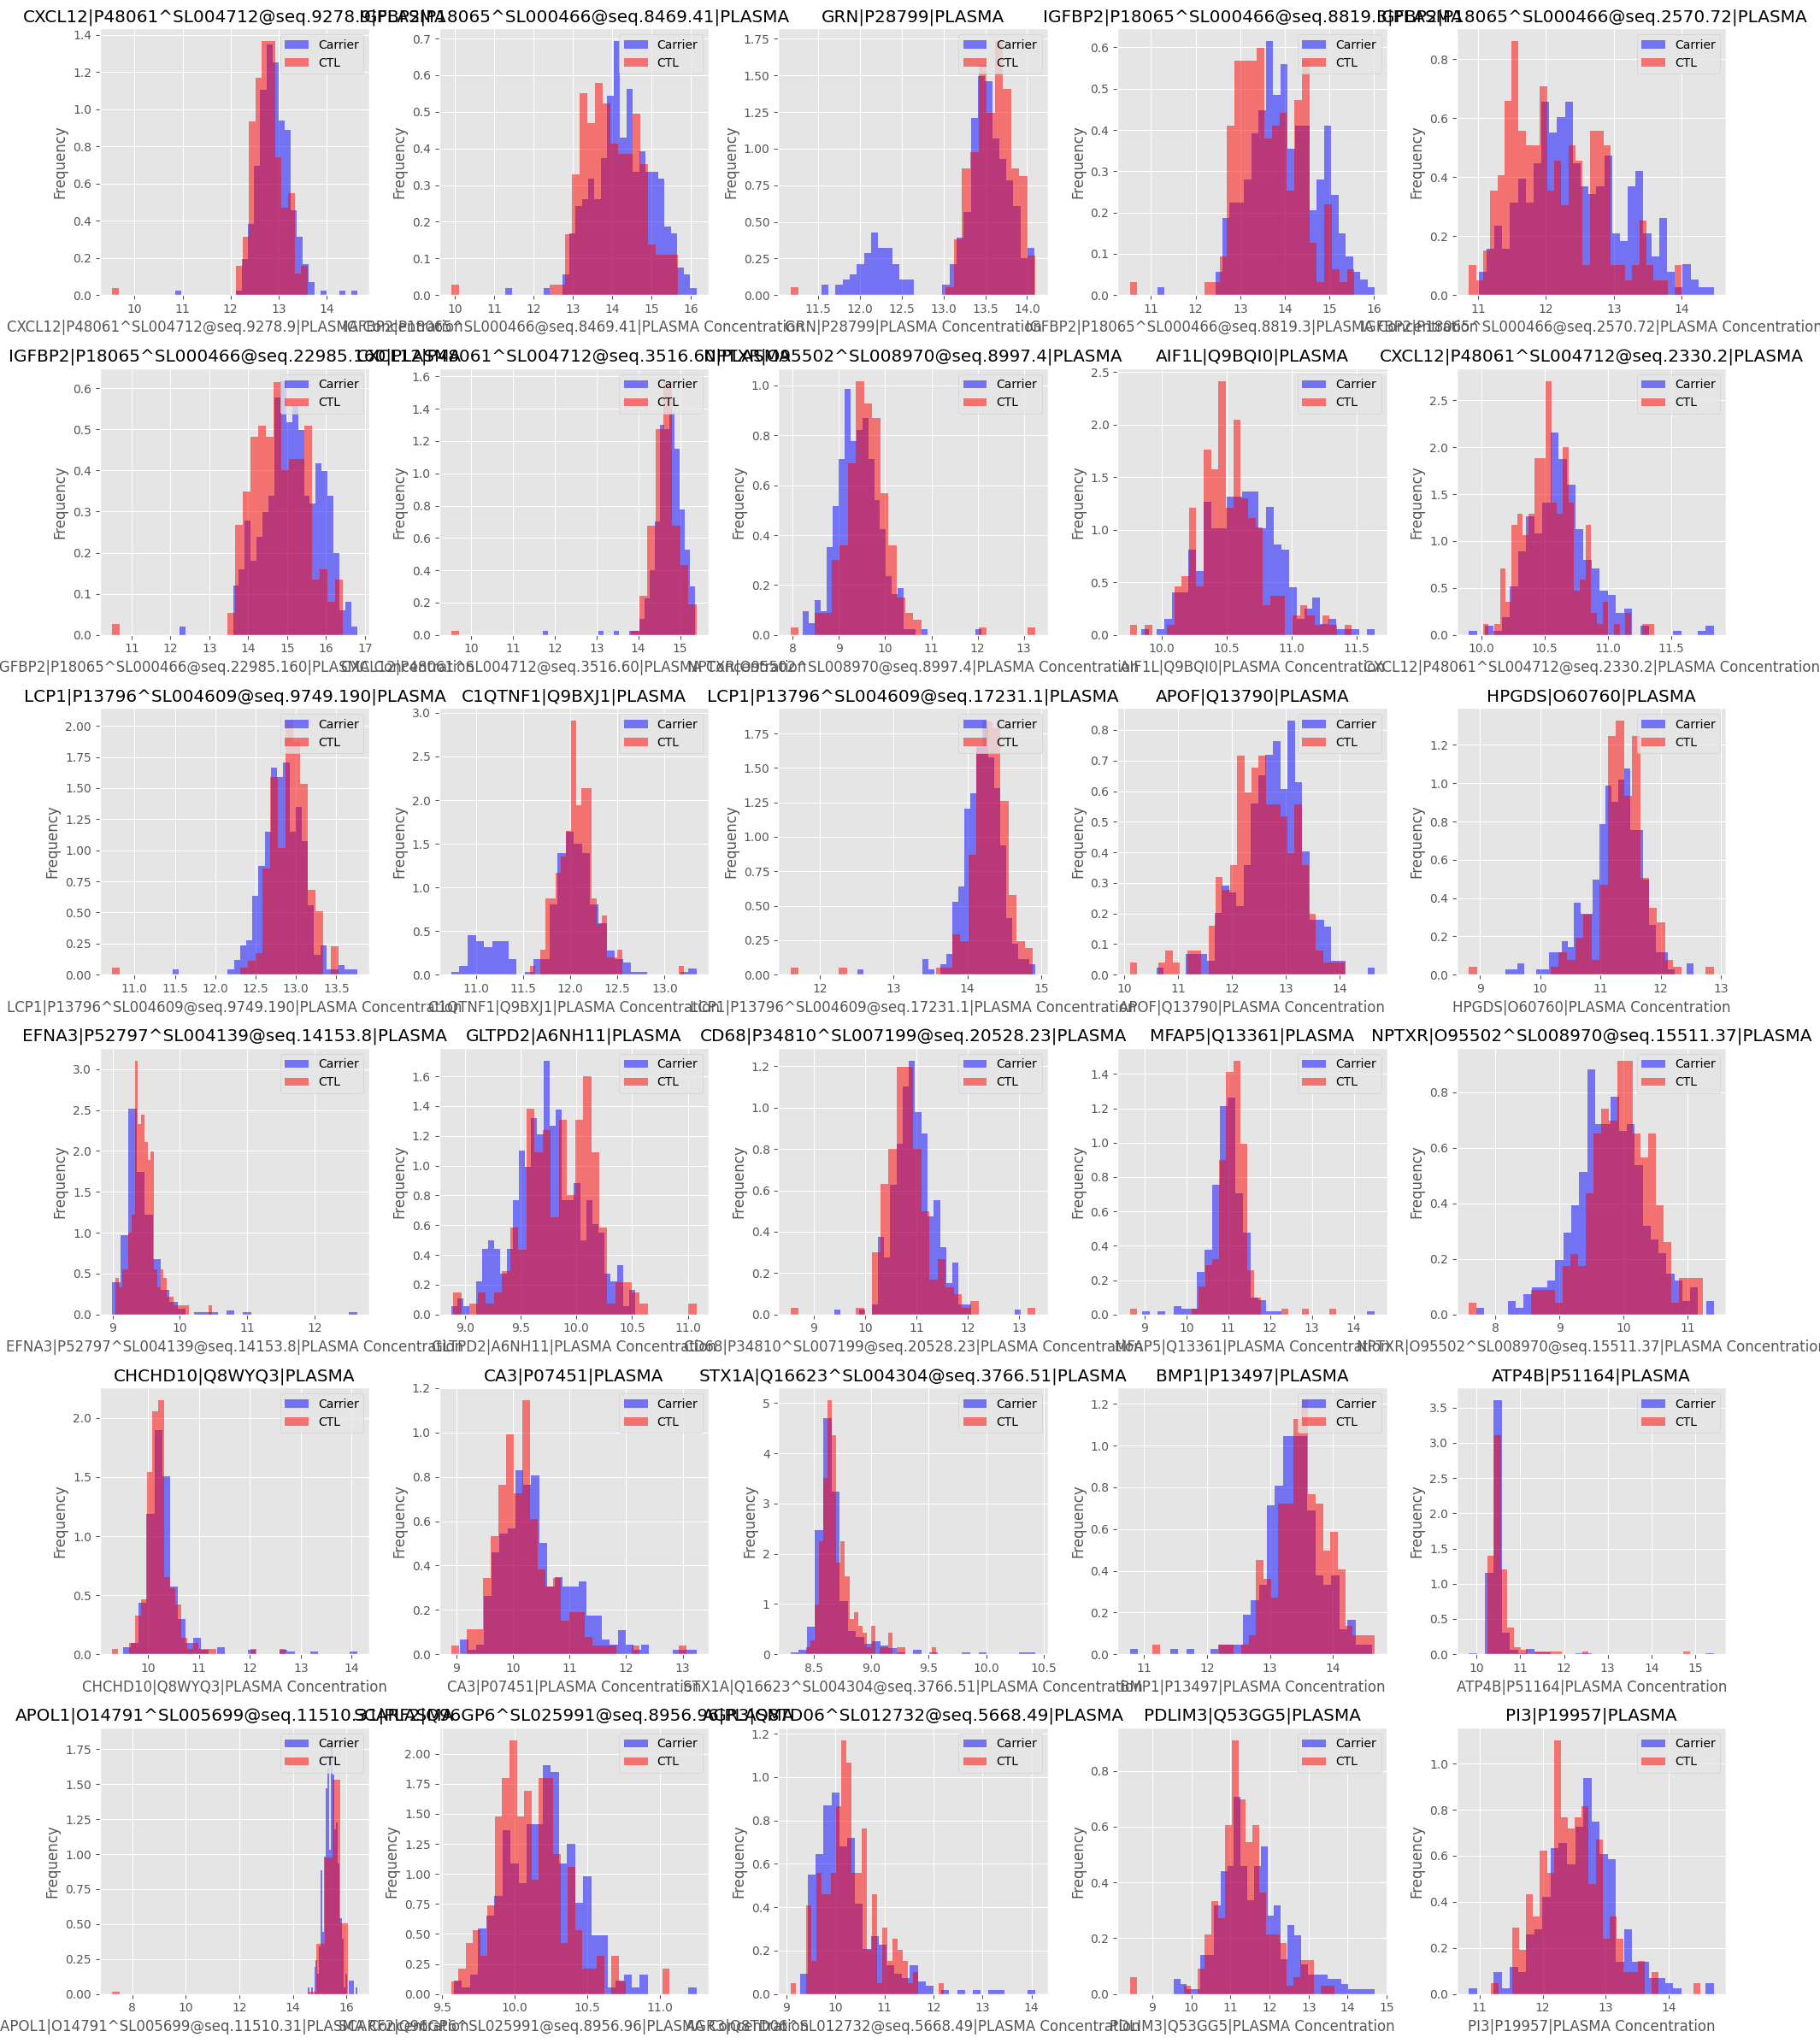

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency, ttest_ind
import numpy as np

# Define the number of plots per row
plots_per_row = 5

# Calculate the number of rows needed
num_rows = (30 + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the first 30 protein columns (assuming they are columns 10 to 39)
for plot_index, i in enumerate(top_30_columns['Column'].values[:30]):
    protein_column = data.columns[i]
    
    # Separate data by "Carrier" and "CTL"
    carrier_data = data[data['Carrier.Status'] == 'Carrier'][protein_column]
    ctl_data = data[data['Carrier.Status'] == 'CTL'][protein_column]

    # Plotting the histograms on the respective subplot
    ax = axes[plot_index]
    ax.hist(carrier_data, bins=30, alpha=0.5, label='Carrier', color='blue', density=True)
    ax.hist(ctl_data, bins=30, alpha=0.5, label='CTL', color='red', density=True)
    
    ax.set_xlabel(f'{protein_column} Concentration')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{protein_column}')
    ax.legend(loc='upper right')

# Hide any unused subplots
for j in range(len(top_30_columns['Column'].values[:30]), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


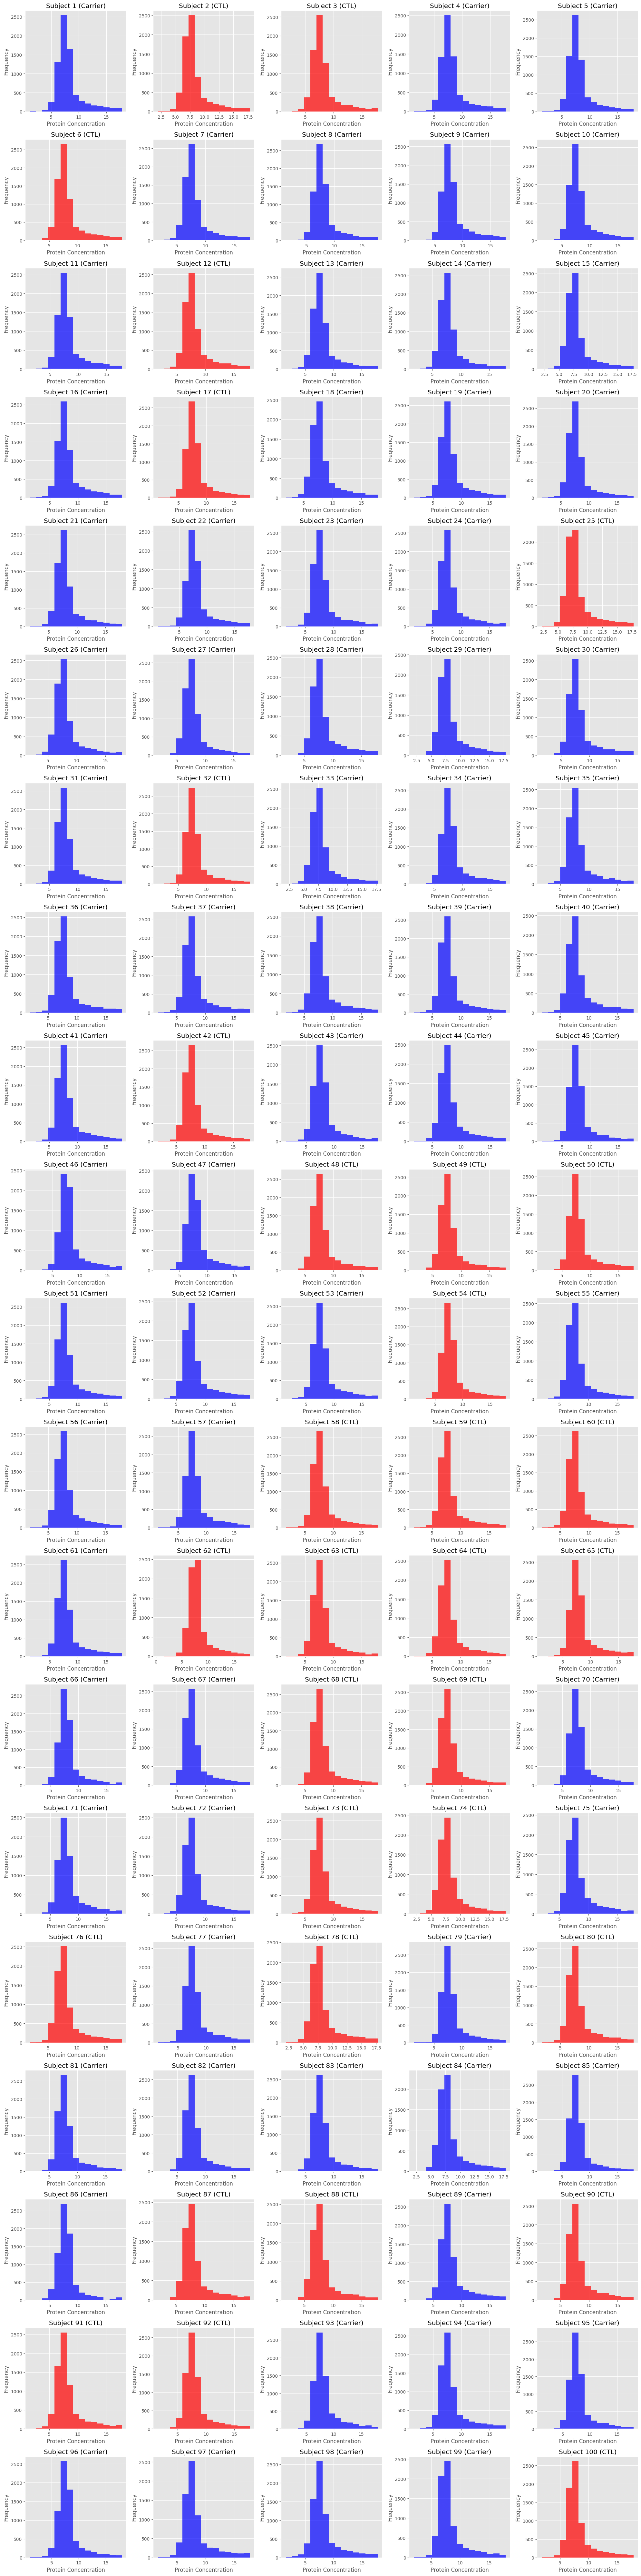

In [11]:
# FOR CSF
# Filter the subjects that have plasma
data = data[data['HasCSF?'] == 1]

# Define the number of subjects to plot
num_subjects = min(100, len(data))  # Plot up to 100 subjects or fewer if less are available

# Define the number of plots per row
plots_per_row = 5

# Calculate the number of rows needed
num_rows = (num_subjects + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the filtered subjects
for i in range(num_subjects):
    subject_data = data.iloc[i, 7300:14588]  # Assuming protein columns start from column 7300
    subject_data = pd.to_numeric(subject_data, errors='coerce').dropna()  # Convert to numeric and drop NaNs
    carrier = data.iloc[i]['Carrier.Status']
    
    # Plotting the histogram on the respective subplot
    ax = axes[i]
    color = 'blue' if carrier == 'Carrier' else 'red'
    
    ax.hist(subject_data, bins=15, alpha=0.7, color=color)  # Reduce bin size to 15
    
    ax.set_xlabel('Protein Concentration')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Subject {i + 1} ({carrier})')

# Hide any unused subplots
for j in range(num_subjects, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

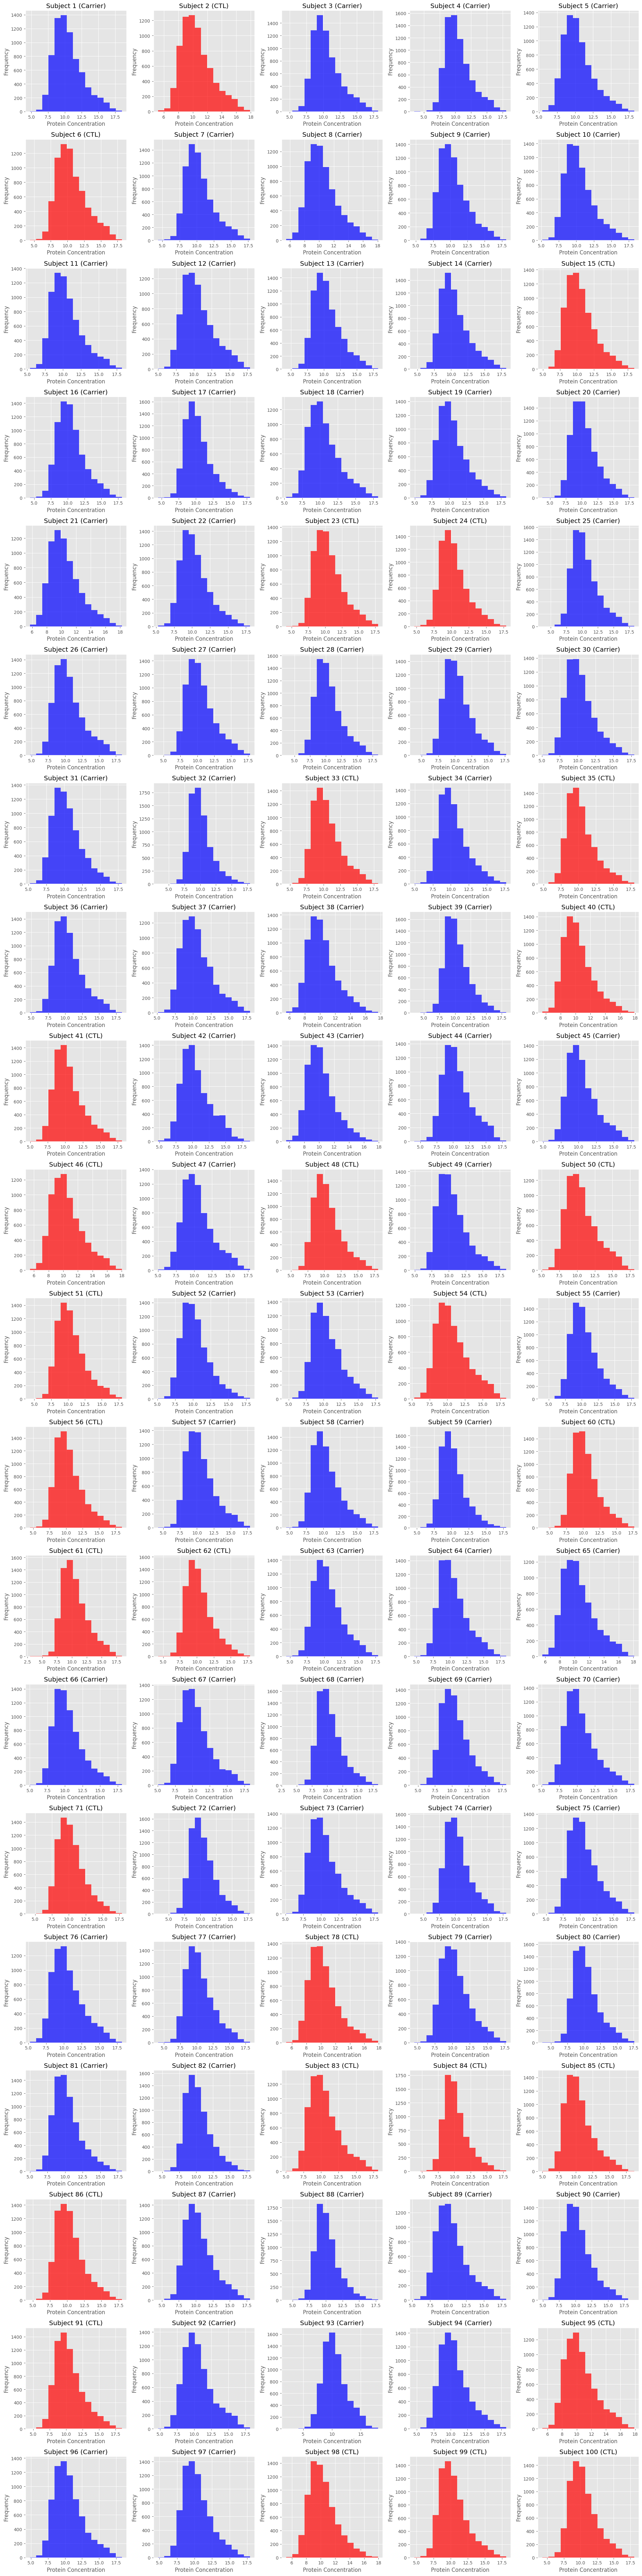

In [14]:
# FOR PLASMA
# Filter the subjects that have plasma
data = data[data['HasPlasma?'] == 1]

# Define the number of subjects to plot
num_subjects = min(100, len(data))  # Plot up to 100 subjects or fewer if less are available

# Define the number of plots per row
plots_per_row = 5

# Calculate the number of rows needed
num_rows = (num_subjects + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the filtered subjects
for i in range(num_subjects):
    subject_data = data.iloc[i, 10:7299]  # Assuming protein columns start from column 10
    subject_data = pd.to_numeric(subject_data, errors='coerce').dropna()  # Convert to numeric and drop NaNs
    carrier = data.iloc[i]['Carrier.Status']
    
    # Plotting the histogram on the respective subplot
    ax = axes[i]
    color = 'blue' if carrier == 'Carrier' else 'red'
    
    ax.hist(subject_data, bins=15, alpha=0.7, color=color)  # Reduce bin size to 15
    
    ax.set_xlabel('Protein Concentration')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Subject {i + 1} ({carrier})')

# Hide any unused subplots
for j in range(num_subjects, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
import os
import numpy as np
import pandas as pd

ROOT_DIR = "/home/lcornelis/code/proteo/proteo/datasets"

ADJACENCY_FOLDER = os.path.join(ROOT_DIR, "data", "ftd", "processed")
ADJACENCY_PATH = os.path.join(ADJACENCY_FOLDER, "adjacency_matrix.csv")

adj_matrix = np.array(pd.read_csv(ADJACENCY_PATH, header=None)).astype(float)
print(adj_matrix.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/home/lcornelis/code/proteo/proteo/datasets/data/ftd/processed/adjacency_matrix.csv'

[[1.00000000e+00 2.94577883e-18 3.11111801e-16 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.01899954e-20 2.60682698e-15
  0.00000000e+00 8.16051511e-16]
 [2.94577883e-18 1.00000000e+00 9.97834977e-15 0.00000000e+00
  1.83788814e-18 2.62354371e-10 0.00000000e+00 2.90848550e-42
  0.00000000e+00 0.00000000e+00]
 [3.11111801e-16 9.97834977e-15 1.00000000e+00 2.88825051e-11
  4.56613120e-05 1.58452736e-12 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.88825051e-11 1.00000000e+00
  3.02523755e-10 4.31894708e-12 8.61297466e-19 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83788814e-18 4.56613120e-05 3.02523755e-10
  1.00000000e+00 4.52341452e-13 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.62354371e-10 1.58452736e-12 4.31894708e-12
  4.52341452e-13 1.00000000e+00 0.00000000e+00 0.00000000e+00
  5.05221196e-13 0.00000000e+00]
 [8.01899954e-20 0.00000000e+00 0.00000000e+00 8.61297466e

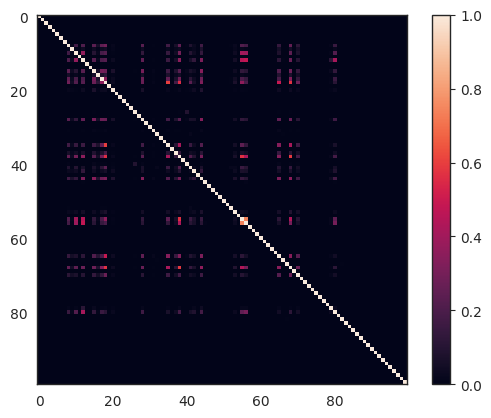

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(adj_matrix[:100, :100])
print(adj_matrix[:10, :10])
plt.colorbar();

GENE EXPRESSION
[[ 0.66964212  0.58538565  0.35485345 ... -0.01034843 -0.38245669
  -0.05489181]
 [-0.68817519  0.18888072 -0.74462287 ...  2.18237716 -0.04916946
  -0.79982196]
 [-0.4877586  -0.36223118 -0.11340701 ...  0.0828062   5.0595944
   0.03592251]
 ...
 [-0.52203773  0.2164463   0.92699325 ... -0.72879074 -0.01126569
  -0.45136942]
 [-0.52203773  0.2164463   0.92699325 ... -0.72879074 -0.01126569
  -0.45136942]
 [-0.76320501 -0.09266775 -1.10607382 ...  0.84001543 -0.60056964
  -0.6222556 ]]
calculating adjacency matrix ...
	Done..

[[1.00000000e+00 1.67622896e-03 3.06770457e-06 0.00000000e+00
  0.00000000e+00]
 [1.67622896e-03 1.00000000e+00 1.92919151e-07 0.00000000e+00
  0.00000000e+00]
 [3.06770457e-06 1.92919151e-07 1.00000000e+00 6.44152068e-06
  3.00126511e-04]
 [0.00000000e+00 0.00000000e+00 6.44152068e-06 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.00126511e-04 0.00000000e+00
  1.00000000e+00]]
[[1.00000000e+00 5.58406785e-04 0.00000000e+00 0.0

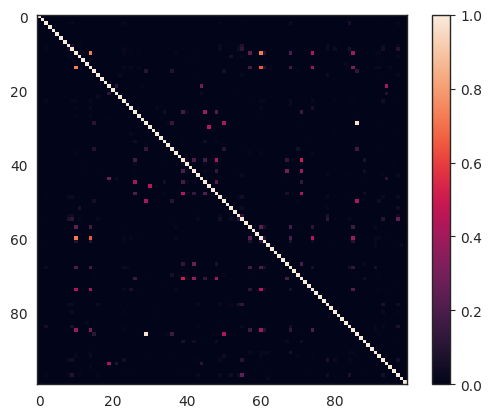

In [ ]:
import PyWGCNA
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT_DIR = "/home/lcornelis/code/proteo/"
EXPRESSION_FOLDER = os.path.join(ROOT_DIR, "MLA-GNN", "example_data", "input_features_labels")
ADJ_FOLDER = os.path.join(ROOT_DIR, "MLA-GNN", "example_data", "input_adjacency_matrix")

# WGCNA parameters
# Probably not necessary since 6 is the default
wgcna_power = 6
wgcna_minModuleSize = 10
wgcna_mergeCutHeight = 0.25


# Read data
geneExp = pd.read_csv(os.path.join(EXPRESSION_FOLDER, "split1_train_320d_features_labels.csv"), header=None) # col = genes, rows = samples 

# Convert the relevant part of the DataFrame to a matrix
geneExp = geneExp.iloc[1:, 82:322].values.astype(float)

# Replace NA values with 0
geneExp = np.nan_to_num(geneExp)
print("GENE EXPRESSION")
print(geneExp[0:10])

# Calculate adjacency matrix.
adjacency = PyWGCNA.WGCNA.adjacency(geneExp, power = wgcna_power, adjacencyType="signed hybrid")
print(adjacency[:5, :5])
plt.imshow(adjacency[:100, :100])
plt.colorbar();

real_adj = np.array(
        pd.read_csv(ADJ_FOLDER +'/'+ 'split1' + '_adjacency_matrix.csv', header=None),
    ).astype(float)
print("============")
print(real_adj[:5, :5])


Shape (7289, 7289)
Threshold: 0.0001
Number of edges tensor(6233217.)
Average degree: 427.57696533203125 for threshold 0.0001


/tmp/ipykernel_3247001/3731686797.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_tensor = torch.tensor(adj_matrix_new)


EDGE INDEX SHAPE torch.Size([2, 6233217])


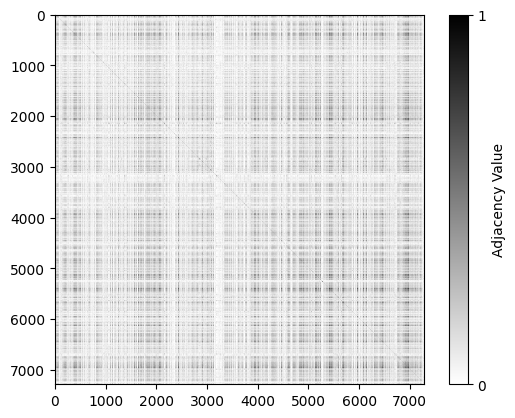

: 

In [ ]:
#ADJANCENCY THRESHOLDING

ROOT_DIR = "/home/lcornelis/code/proteo/proteo/datasets"
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

ADJACENCY_FOLDER = os.path.join(ROOT_DIR, "data", "ftd", "processed")
ADJACENCY_PATH = os.path.join(ADJACENCY_FOLDER, "adjacency_matrix.csv")
adj_matrix = np.array(pd.read_csv(ADJACENCY_PATH, header=None)).astype(float)
print("Shape", adj_matrix.shape)

for threshold in [0.0001]:#, 0.001, 0.01, 0.08, 0.1, 0.5]:
    adj_matrix_new = torch.FloatTensor(
        np.where(adj_matrix > threshold, 1, 0)
    )
    print(f"Threshold: {threshold}")
    Average_degree = (adj_matrix_new.sum()/2) / (adj_matrix_new.shape[0])
    print("Number of edges", adj_matrix_new.sum())
    print(f"Average degree: {Average_degree} for threshold {threshold}")

    adj_tensor = torch.tensor(adj_matrix_new)
    # Find the indices where the matrix has non-zero elements
    pairs_indices = torch.nonzero(adj_tensor, as_tuple=False)
    # Extract the pairs of connected nodes
    edge_index = torch.tensor(pairs_indices.tolist())
    edge_index = torch.transpose(edge_index, 0, 1)  # reshape(edge_index, (2, -1))
    print("EDGE INDEX SHAPE", edge_index.shape)

    plt.figure()
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "black"])
    plt.imshow(adj_matrix_new, cmap=cmap) #0 = white, 1 = black
    plt.colorbar(ticks=[0, 1], label='Adjacency Value')  # Optional



/tmp/ipykernel_949072/3388243827.py:7: DtypeWarning: Columns (14932,14938,14939,15011,15013,15014,15015,15016) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('~/code/proteo/data/raw/ALLFTD_dataset_for_nina_louisa_071124.csv')


2.187675633915814
0      False
1      False
2      False
3      False
4      False
       ...  
525    False
526    False
527    False
528    False
529    False
Name: NFL3_MEAN, Length: 530, dtype: bool


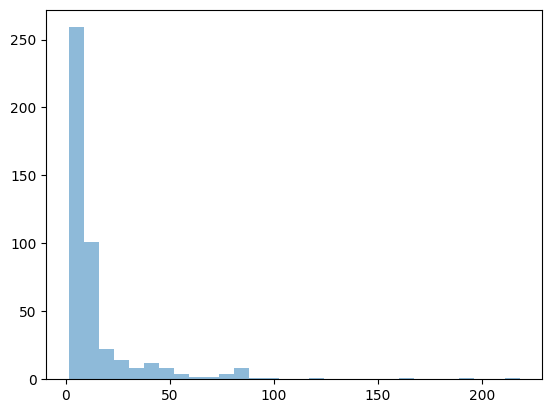

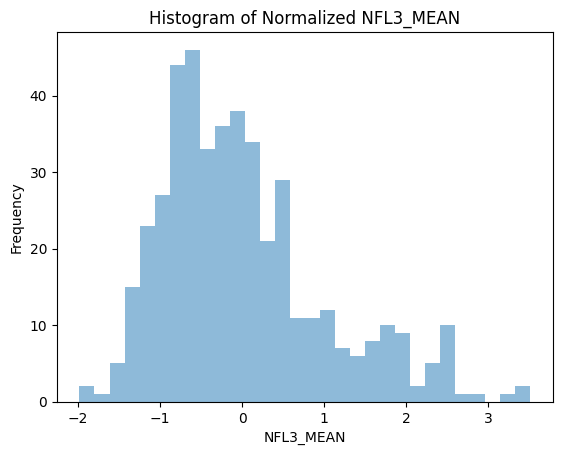

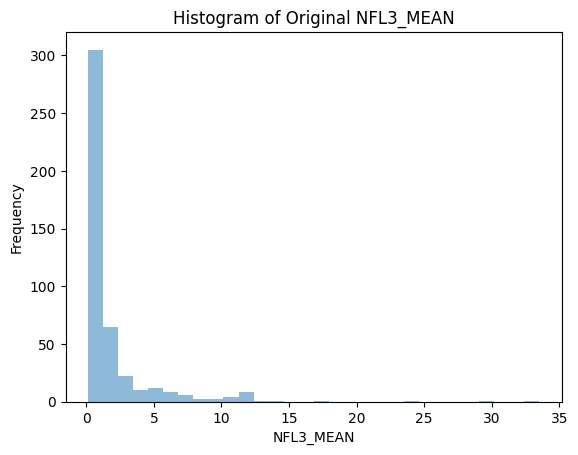

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv('~/code/proteo/data/raw/ALLFTD_dataset_for_nina_louisa_071124.csv')

plt.hist(data['NFL3_MEAN'], bins=30, alpha=0.5, label='NFL3_MEAN');

#Normalizing data:

# Sample data with positive values
data = data['NFL3_MEAN']

# Log transformation
log_data = np.log(data)

# Optional: Standardize the log-transformed data
mean = np.mean(log_data)
print(mean)
std = np.std(log_data)
standardized_log_data = (log_data - mean) / std

plt.figure()
plt.hist(standardized_log_data, bins=30, alpha=0.5, label='NFL3_MEAN');
plt.xlabel('NFL3_MEAN')
plt.ylabel('Frequency')
plt.title('Histogram of Normalized NFL3_MEAN')
mean = np.mean(standardized_log_data)
std = np.std(standardized_log_data)
log_data = (standardized_log_data * std) + mean
    
# Reverse the log transformation by applying the exponential function
original_data = np.exp(log_data)
print(original_data == data)

plt.figure()
plt.xlabel('NFL3_MEAN')
plt.ylabel('Frequency')
plt.title('Histogram of Original NFL3_MEAN')
plt.hist(original_data, bins=30, alpha=0.5, label='NFL3_MEAN');



/tmp/ipykernel_949072/365227842.py:1: DtypeWarning: Columns (14932,14938,14939,15011,15013,15014,15015,15016) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('~/code/proteo/data/raw/ALLFTD_dataset_for_nina_louisa_071124.csv')


Frequency of 0: 378
Frequency of 0.5: 61
Frequency of 1: 46
Frequency of 2: 23
Frequency of 3: 11


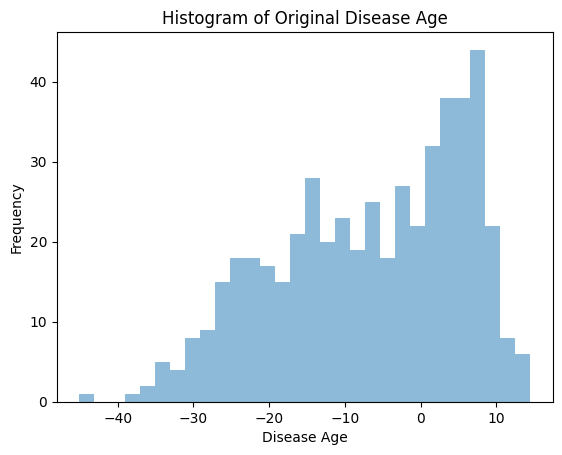

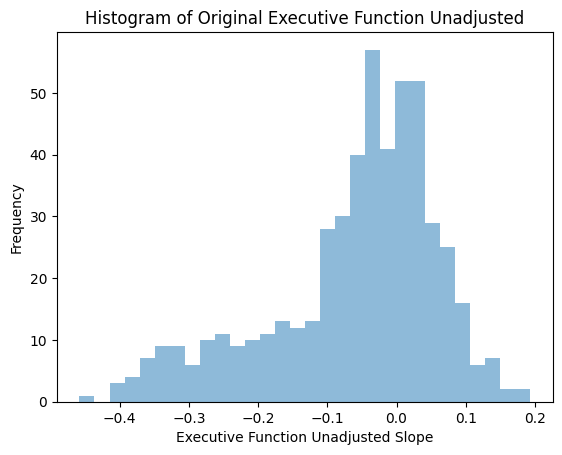

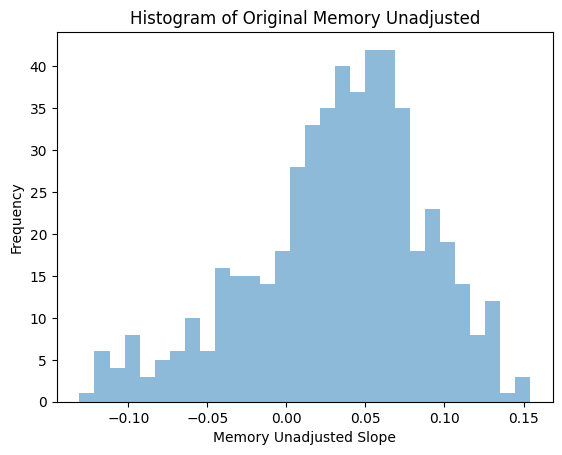

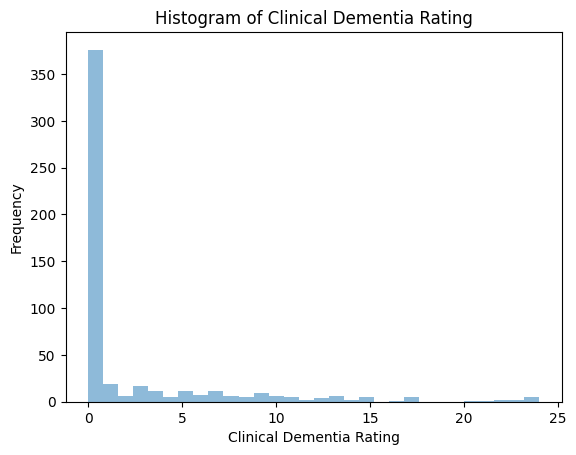

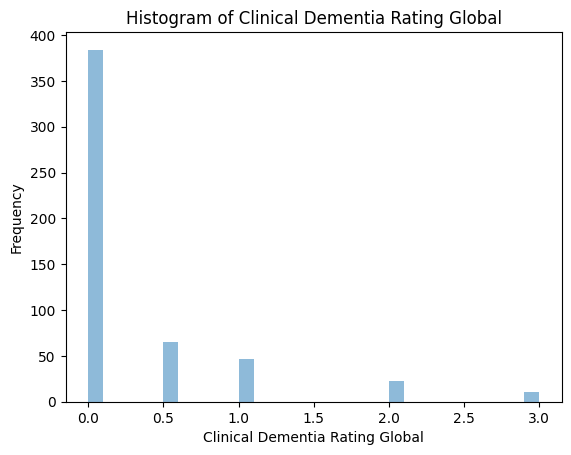

<Figure size 640x480 with 0 Axes>

In [6]:
data = pd.read_csv('~/code/proteo/data/raw/ALLFTD_dataset_for_nina_louisa_071124.csv')

plt.hist(data['disease.age'], bins=30, alpha=0.5, label='Disease Age');
plt.xlabel('Disease Age')
plt.ylabel('Frequency')
plt.title('Histogram of Original Disease Age')
plt.figure()

plt.hist(data['ef.unadj.slope'], bins=30, alpha=0.5, label='Disease Age');
plt.xlabel('Executive Function Unadjusted Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Original Executive Function Unadjusted')
plt.figure()

plt.hist(data['mem.unadj.slope'], bins=30, alpha=0.5, label='Disease Age');
plt.xlabel('Memory Unadjusted Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Original Memory Unadjusted')
plt.figure()

plt.hist(data['FTLDCDR_SB'], bins=30, alpha=0.5, label='');
plt.xlabel('Clinical Dementia Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Clinical Dementia Rating')
plt.figure()

plt.hist(data['CDRGLOB'], bins=30, alpha=0.5, label='');
plt.xlabel('Clinical Dementia Rating Global')
plt.ylabel('Frequency')
plt.title('Histogram of Clinical Dementia Rating Global')
plt.figure()

has_measurement = data['HasPlasma?'].astype(int) == 1
cdrglob_values = data.loc[has_measurement, 'CDRGLOB'].astype(float)
specific_values = [0, 0.5, 1, 2, 3]
for value in specific_values:
    count = (cdrglob_values == value).sum()
    print(f'Frequency of {value}: {count}')


In [4]:
import numpy as np

def reverse_log_transform(standardized_log_data, mean, std):
    # De-standardize the data
    log_data = standardized_log_data * std + mean
    original_data = np.exp(log_data)
    return original_data

converted = reverse_log_transform(np.array([0.040640295, 0.110063404, 0.17069, 0.273345172, 0.315212935, 0.335949302, 
 0.387901604, 0.428061336, 0.479374737, 0.488184899]),2.178815827183045, 0.7776541040264751)
print(converted)

sqrt_converted = np.sqrt(converted)
print(sqrt_converted)

print(reverse_log_transform(np.sqrt(np.array([0.040640295, 0.110063404, 0.17069, 0.273345172, 0.315212935, 0.335949302, 
 0.387901604, 0.428061336, 0.479374737, 0.488184899])),2.178815827183045, 0.7776541040264751))

[ 9.11954506  9.62541586 10.09008851 10.92860673 11.29028317 11.47382301
 11.9468674  12.32585985 12.8276572  12.91584455]
[3.01985845 3.10248543 3.17648997 3.30584433 3.36010166 3.38730321
 3.45642408 3.5108204  3.58157189 3.59386207]
[10.3355202  11.43648675 12.18372287 13.26849241 13.67296608 13.86756919
 14.3414277  14.69646347 15.13847276 15.21321618]


In [14]:
#-----------------RUNNING LINEAR REGRESSION----------------------
from datasets.ftd import HAS_MODALITY_COL, Y_VAL_COL_MAP, MODALITY_COL_END, mutation_col, sex_col, Y_VALS_TO_NORMALIZE, log_transform, BINARY_Y_VALS_MAP, MULTICLASS_Y_VALS_MAP, FTDDataset
from sklearn import linear_model
import os
import pandas as pd
import numpy as np
from config_utils import CONFIG_FILE, Config, read_config_from_file
from sklearn.metrics import mean_squared_error, r2_score

config = read_config_from_file(CONFIG_FILE)
root = config.data_dir
train_dataset = FTDDataset(root, "train", config)
csv_data = pd.read_csv(os.path.join(config.data_dir, "raw", config.raw_file_name))
# Remove bimodal columns
csv_data = train_dataset.remove_erroneous_columns(config, csv_data)
# Get the correct subset of proteins based on the mutation, if they have the correct modality measurements, and sex and then use those to find the top proteins and labels
condition_sex = csv_data[sex_col].isin(config.sex)
condition_modality = csv_data[HAS_MODALITY_COL[config.modality]]
condition_mutation = csv_data[mutation_col].isin(config.mutation)
sex_mutation_modality_filter = condition_sex & condition_mutation & condition_modality
print("Number of patients with measurements:", condition_modality.sum())
print(
    f"Number of patients with mutation status in {config.mutation}:",
    condition_mutation.sum(),
)
print(f"Number of patients with sex in {config.sex}", condition_sex.sum())
print("Total number of patients with all conditions", sex_mutation_modality_filter.sum())
filtered_data = csv_data[
    sex_mutation_modality_filter
]  # Select rows that meet all conditions
y_vals, y_val_mask = train_dataset.load_y_vals(filtered_data)
filtered_data = filtered_data[y_val_mask]
top_protein_columns = train_dataset.find_top_proteins(filtered_data, y_vals)
top_proteins = filtered_data[top_protein_columns]

features = np.array(top_proteins)
labels = np.array(y_vals)
print("Features shape", features.shape)
print("Labels shape", labels.shape)

clf = linear_model.Lasso()
# Fit the model
clf.fit(features, labels)
# Predict Using the model
predictions = clf.predict(features)
print("Predictions", predictions)
print("Labels", labels)
# Mean Squared Error
mse = mean_squared_error(labels, predictions)
print("Mean Squared Error:", mse)
# Coefficient of Determination
r2 = r2_score(labels, predictions)
print("Coefficient of Determination:", r2)





Loading data from: /home/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.1_num_nodes_7000_mutation_GRN_plasma_sex_M_train.pt
Number of patients with measurements: 519
Number of patients with mutation status in ['GRN']: 73
Number of patients with sex in ['M'] 231
Total number of patients with all conditions 37
mean log 2.3840692826511245
std log 0.9650973053482799
Features shape (33, 7000)
Labels shape (33,)
Predictions [-4.37360585e-17 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17
 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17
 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17
 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17
 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17
 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17
 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17
 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17 -4.37360585e-17
 -4.37360585e-17]
Labels [ 1.39198653 -1.08741903  